# 1 - Source Text Filtering

In [1]:
import sys
print(sys.version)

3.5.2 |Continuum Analytics, Inc.| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


In [2]:
# Use AzureML's data collector to log various metrics!
#from azureml.logging import current_scriptrun
#logger = current_scriptrun()

import string, re
import pandas as pd
from nltk.corpus import stopwords
from gensim import corpora, models, similarities
import azureml
from __future__ import division
import numpy as np
import nltk
from nltk.corpus import stopwords
from azure.storage.blob import BlockBlobService

C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Import source text and write to a pandas dataframe

In [3]:
import os
os.getcwd()

'C:\\Users\\pattyry\\Documents\\AzureML\\NextAgenda_CodeStory\\NextAgenda_CodeStory'

In [4]:
import pickle
with open('Data2.pkl', 'rb') as f:
    data = pickle.load(f)
    print("Data unpickled")
    import pandas as pd
data = pd.DataFrame(data)
data.shape

Data unpickled


(32233, 16)

Review data

In [5]:
print('data shape',data.head(2))

data["count"]=data['Text'].str.len()
data = data[data['count']>45]
print('data shape',data.shape)

data shape   Ticker  Year Month Day        Date        Category Category Number  \
1    AAL  2014    02  28  2014-02-28  Major Airlines             770   
2    AAL  2013    02  20  2013-02-20  Major Airlines             770   

  Future_4_weeks Future_26_weeks  \
1     2014-03-28      2014-08-29   
2     2013-03-20      2013-08-21   

                                                Text  Label  Price_Date  \
1  OverviewAmerican Airlines Group Inc. (AAG) a D...  Item1   35.798592   
2  Chapter 11 ProceedingsOn November 29, 2011 (th...  Item1   12.921616   

   Price_4_weeks  Price_26_weeks  Return_4_weeks  Return_26_weeks  
1      34.305775       37.784386       -4.178315         0.788191  
2      16.702129       15.325636       25.062782        11.639949  
data shape (31002, 17)


In [6]:
data.head(2)

,Ticker,Year,Month,Day,Date,Category,Category Number,Future_4_weeks,Future_26_weeks,Text,Label,Price_Date,Price_4_weeks,Price_26_weeks,Return_4_weeks,Return_26_weeks,count
1,AAL,2014,02,28,2014-02-28,Major Airlines,770,2014-03-28,2014-08-29,OverviewAmerican Airlines Group Inc. (AAG) a D...,Item1,35.798592,34.305775,37.784386,-4.178315,0.788191,87146
2,AAL,2013,02,20,2013-02-20,Major Airlines,770,2013-03-20,2013-08-21,"Chapter 11 ProceedingsOn November 29, 2011 (th...",Item1,12.921616,16.702129,15.325636,25.062782,11.639949,37564


In [8]:
print(data['Year'].value_counts())
print(data['Label'].value_counts())
#https://www.sec.gov/about/forms/form10-k.pdf
#item 7 Management’s Discussion and Analysis of Financial Condition and Results of Operations
#item 1  Business
#item 1a  Risk Factors. 
#item 7a  Quantitative and Qualitative Disclosures About Market Risk. 
data['Label'] = data['Label'].map({'Item7': 'ManagementDiscussion', 'Item1': 'BusinessOverview', 'Item1A': 'RiskFactors', 'Item7A': 'MarketRisk'})
print('revised labels',data['Label'].value_counts())

2014    4030
2015    3887
2012    3562
2013    3519
2016    3472
2011    2771
2010    2656
2009    2552
2017    2353
2008    2200
Name: Year, dtype: int64
Item7     7995
Item1     7737
Item1A    7713
Item7A    7557
Name: Label, dtype: int64
revised labels ManagementDiscussion    7995
BusinessOverview        7737
RiskFactors             7713
MarketRisk              7557
Name: Label, dtype: int64


Discard some data, Append Ticker to the text.

In [9]:
data1=data.drop(['Month', 'Day','Year'], axis=1)
data1['fulltext'] = data1[['Label', 'Ticker', 'Text']].apply(lambda x: '.   '.join(x), axis=1)
print(data1.shape)
data1.head(2)

(31002, 15)


,Ticker,Date,Category,Category Number,Future_4_weeks,Future_26_weeks,Text,Label,Price_Date,Price_4_weeks,Price_26_weeks,Return_4_weeks,Return_26_weeks,count,fulltext
1,AAL,2014-02-28,Major Airlines,770,2014-03-28,2014-08-29,OverviewAmerican Airlines Group Inc. (AAG) a D...,BusinessOverview,35.798592,34.305775,37.784386,-4.178315,0.788191,87146,BusinessOverview. AAL. OverviewAmerican Ai...
2,AAL,2013-02-20,Major Airlines,770,2013-03-20,2013-08-21,"Chapter 11 ProceedingsOn November 29, 2011 (th...",BusinessOverview,12.921616,16.702129,15.325636,25.062782,11.639949,37564,BusinessOverview. AAL. Chapter 11 Proceedi...


Create calculated normalized percent return, creaate 3 bins

(31002, 19)
  Ticker        Date        Category Category Number Future_4_weeks  \
1    AAL  2014-02-28  Major Airlines             770     2014-03-28   
2    AAL  2013-02-20  Major Airlines             770     2013-03-20   

  Future_26_weeks                                               Text  \
1      2014-08-29  OverviewAmerican Airlines Group Inc. (AAG) a D...   
2      2013-08-21  Chapter 11 ProceedingsOn November 29, 2011 (th...   

              Label  Price_Date  Price_4_weeks  Price_26_weeks  \
1  BusinessOverview   35.798592      34.305775       37.784386   
2  BusinessOverview   12.921616      16.702129       15.325636   

   Return_4_weeks  Return_26_weeks  count  \
1       -4.178315         0.788191  87146   
2       25.062782        11.639949  37564   

                                            fulltext  PercReturn_4_Weeks  \
1  BusinessOverview.   AAL.   OverviewAmerican Ai...           -0.116717   
2  BusinessOverview.   AAL.   Chapter 11 Proceedi...            1.9396

C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


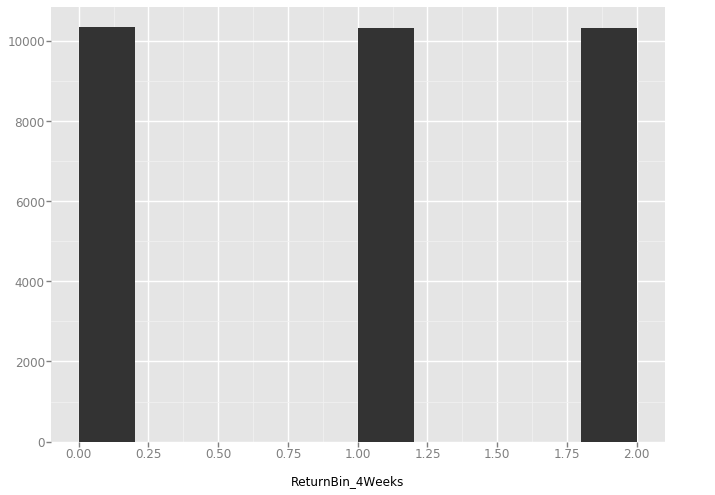

<ggplot: (-9223371944201031869)>

In [10]:
data2=data1
data2["PercReturn_4_Weeks"] = data2.Return_4_weeks / data2.Price_Date
data2["PercReturn_26_Weeks"] = data2.Return_26_weeks / data2.Price_Date
data2["ReturnBin_4Weeks"] = pd.qcut(data2["PercReturn_4_Weeks"], 3,labels=range(3))
data2["ReturnBin_26Weeks"] = pd.qcut(data2["PercReturn_26_Weeks"], 3,labels=range(3))
referencedata=data2
print(data2.shape)
print(data2.head(2))
import ggplot
from ggplot import *
ggplot(data2, aes(x='ReturnBin_4Weeks')) + \
    geom_histogram() 

In [11]:
df=data2
data1['fulltext'] = data1[['Label', 'Ticker', 'Text']].apply(lambda x: '.   '.join(x), axis=1)
df=df.drop(['Text','Ticker','Category Number','Label'], axis=1)
print(df.shape)

(31002, 15)


In [12]:
allindustrydata=df
allindustrydata=allindustrydata.drop(['PercReturn_4_Weeks',
                                      'Future_4_weeks','Future_26_weeks','Date','Price_4_weeks','Price_26_weeks','Price_Date','PercReturn_26_Weeks','Return_4_weeks','Return_26_weeks'], axis=1)
print(allindustrydata.Category.unique())
allindustrydata.head(2)

['Major Airlines' 'Rental & Leasing Services' 'General Building Materials'
 'Electronic Equipment' 'Auto Parts Stores' 'Air Services'
 'Drugs Wholesale' 'Auto Dealerships' 'Medical Appliances & Equipment'
 'REIT - Diversified' 'Biotechnology' 'Office Supplies'
 'REIT - Residential' 'Property & Casualty Insurance'
 'Technical & System Software' 'Semiconductor Equipment & Materials'
 'Technical Services' 'Information Technology Services'
 'Application Software' 'Business Services' 'Housewares & Accessories'
 'Property Management' 'Semiconductor - Integrated Circuits'
 'Long-Term Care Facilities' 'Farm Products' 'Business Software & Services'
 'Electric Utilities' 'Diversified Electronics' 'Life Insurance'
 'Apparel Stores' 'Health Care Plans' 'Home Health Care' ''
 'Farm & Construction Machinery' 'Credit Services' 'Drugs - Generic'
 'REIT - Hotel/Motel' 'Aerospace/Defense Products & Services'
 'Accident & Health Insurance' 'Mortgage Investment' 'Insurance Brokers'
 'Aerospace/Defense - M

,Category,count,fulltext,ReturnBin_4Weeks,ReturnBin_26Weeks
1,Major Airlines,87146,BusinessOverview. AAL. OverviewAmerican Ai...,0,1
2,Major Airlines,37564,BusinessOverview. AAL. Chapter 11 Proceedi...,2,2


In [13]:
with open('allindustriessource.pkl', 'wb') as f:
    pickle.dump(allindustrydata, f)
#df = pd.read_pickle(file_name)

In [14]:

df1 = df[(df['Category'] =="Biotechnology")]
print(df1['Category'].value_counts())
df1.shape
df1.head(2)

Biotechnology    921
Name: Category, dtype: int64


,Date,Category,Future_4_weeks,Future_26_weeks,Price_Date,Price_4_weeks,Price_26_weeks,Return_4_weeks,Return_26_weeks,count,fulltext,PercReturn_4_Weeks,PercReturn_26_Weeks,ReturnBin_4Weeks,ReturnBin_26Weeks
131,2008-03-05,Biotechnology,2008-04-02,2008-09-03,9.30,8.990000,2.690000,-6.196167,-65.182894,72955,BusinessOverview. ACAD. . Overview We are ...,-0.666255,-7.008913,0,0
133,2016-02-29,Biotechnology,2016-03-28,2016-08-29,17.26,23.809999,32.619999,31.780087,76.964577,74741,BusinessOverview. ACAD. . Company Overview...,1.841257,4.459130,2,2


C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pattyry\AppData\local\AmlWorkbench\Python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

(921, 15)


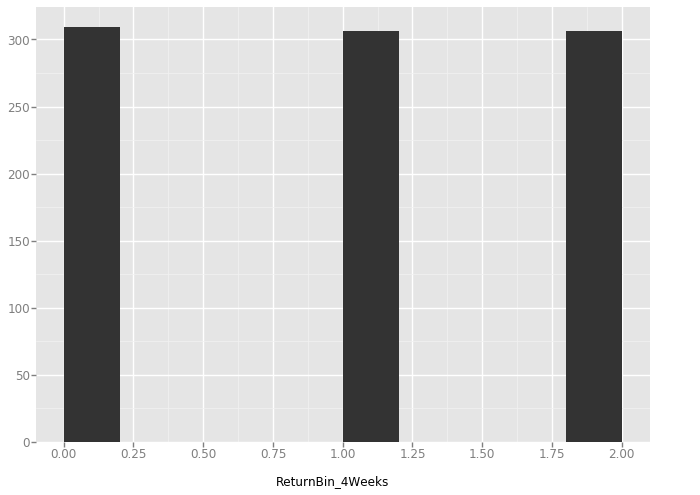

<ggplot: (-9223371944201034983)>

In [15]:
data2=df1
data2["PercReturn_4_Weeks"] = data2.Return_4_weeks / data2.Price_Date
data2["PercReturn_26_Weeks"] = data2.Return_26_weeks / data2.Price_Date
data2["ReturnBin_4Weeks"] = pd.qcut(data2["PercReturn_4_Weeks"], 3,labels=range(3))
data2["ReturnBin_26Weeks"] = pd.qcut(data2["PercReturn_26_Weeks"], 3,labels=range(3))
referencedata=data2
print(data2.shape)
data2.head(2)
import ggplot
from ggplot import *
ggplot(data2, aes(x='ReturnBin_4Weeks')) + \
    geom_histogram() 

In [16]:
data2=data2.drop(['PercReturn_4_Weeks','Category',
                    'Future_4_weeks','Future_26_weeks','Date','Price_4_weeks','Price_26_weeks',
                    'Price_Date','PercReturn_26_Weeks','Return_4_weeks','Return_26_weeks'], axis=1)

print(data2.shape)
data2.head(2)

(921, 4)


,count,fulltext,ReturnBin_4Weeks,ReturnBin_26Weeks
131,72955,BusinessOverview. ACAD. . Overview We are ...,0,0
133,74741,BusinessOverview. ACAD. . Company Overview...,2,2


In [17]:
with open('biotechsource.pkl', 'wb') as f:
    pickle.dump(data2, f)
#df = pd.read_pickle(file_name)